In [64]:
!pip install pandas matplotlib seaborn scikit-learn plotly

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.9 MB 294.7 kB/s eta 0:00:32
   -- ------------------------------------- 0.5/9.9 MB 294.7 kB/s eta 0:00:32
   -- ------------------------------------- 0.5/9.9 MB 294.7 kB/s eta 0:00:32
   ---- ----------------------------------- 1.0/9.9 MB 478.1 kB/s eta 0:00:19
   ---- ----------------------------------- 1.0/9.9 MB 478.1 kB/s eta 0:00:19
   ----- ---------------------------------- 1.3/9.9 MB 491.7 kB/s eta 0:00:18
   ------ --------------------------------- 1.6/9.9 MB 593.8 kB/s eta 0:00:15
   ------ ------------------------------

In [1]:
!pip install -r ../requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import warnings
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import norm


warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 6)


print('Bibliotecas carregadas com sucesso.')

Bibliotecas carregadas com sucesso.


## 1. Carregamento dos Dados

Leitura e concatenação dos arquivos CSV do CPGF (a partir de 2022) armazenados na pasta `datasets`.

> **Nota:** Os CSVs do Portal da Transparência utilizam separador `;` e encoding `latin-1`.

In [3]:
# --- Definição de caminhos ---
# Execução local:
# --- Carregamento de todos os CSVs ---

csv_files = sorted(glob.glob(os.path.join("../datasets", '*.csv')))
print(f'Arquivos encontrados: {len(csv_files)}')

aux=0
dfs = []

for f in csv_files:
    df_temp = pd.read_csv(f, sep=';', encoding='latin-1', decimal = ',')
    dfs.append(df_temp)
    aux+=1
    if aux <= 3:
        print(f'  - {os.path.basename(f)}')
    elif aux == 3:    
        print("  - ...")

df = pd.concat(dfs, ignore_index=True)

print(f'\nTotal de registros carregados: {df.shape[0]:,}')

print(f'Total de colunas: {df.shape[1]} \n')

print(f'Nomes das Colunas: {df.columns}')

Arquivos encontrados: 36
  - 202201_CPGF.csv
  - 202202_CPGF.csv
  - 202203_CPGF.csv

Total de registros carregados: 411,652
Total de colunas: 15 

Nomes das Colunas: Index(['CÓDIGO ÓRGÃO SUPERIOR', 'NOME ÓRGÃO SUPERIOR', 'CÓDIGO ÓRGÃO',
       'NOME ÓRGÃO', 'CÓDIGO UNIDADE GESTORA', 'NOME UNIDADE GESTORA',
       'ANO EXTRATO', 'MÊS EXTRATO', 'CPF PORTADOR', 'NOME PORTADOR',
       'CNPJ OU CPF FAVORECIDO', 'NOME FAVORECIDO', 'TRANSAÇÃO',
       'DATA TRANSAÇÃO', 'VALOR TRANSAÇÃO'],
      dtype='str')


## 2. Tipos de dados

Altera o tipo dos dados das colunas 'DATA TRANSAÇÃO' e 'VALOR TRANSAÇÃO'

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 411652 entries, 0 to 411651
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CÓDIGO ÓRGÃO SUPERIOR   411652 non-null  int64  
 1   NOME ÓRGÃO SUPERIOR     411652 non-null  str    
 2   CÓDIGO ÓRGÃO            411652 non-null  int64  
 3   NOME ÓRGÃO              411652 non-null  str    
 4   CÓDIGO UNIDADE GESTORA  411652 non-null  int64  
 5   NOME UNIDADE GESTORA    411652 non-null  str    
 6   ANO EXTRATO             411652 non-null  int64  
 7   MÊS EXTRATO             411652 non-null  int64  
 8   CPF PORTADOR            312122 non-null  str    
 9   NOME PORTADOR           411652 non-null  str    
 10  CNPJ OU CPF FAVORECIDO  411652 non-null  int64  
 11  NOME FAVORECIDO         411652 non-null  str    
 12  TRANSAÇÃO               411652 non-null  str    
 13  DATA TRANSAÇÃO          312122 non-null  str    
 14  VALOR TRANSAÇÃO         411652 

In [5]:
#Tipo de dados e criação de id's
# A coluna já está como float, mas se caso não força a transformação str->float
if df['VALOR TRANSAÇÃO'].dtype == 'object':
    df['VALOR TRANSAÇÃO'] = (
        df['VALOR TRANSAÇÃO']
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

# str-> datetime aaaa-mm-dd
df['DATA TRANSAÇÃO'] = pd.to_datetime(
    df['DATA TRANSAÇÃO'],
    format='%d/%m/%Y'
)

#df['ID'] = range(1, len(df) + 1)
print("Tipo alterado em VALOR TRANSAÇÃO para ",df['VALOR TRANSAÇÃO'].dtype)
print("Tipo alterado em DATA TRANSAÇÃO para ",df['DATA TRANSAÇÃO'].dtype, "\n")
print("Sobre as colunas:")
df.dtypes

Tipo alterado em VALOR TRANSAÇÃO para  float64
Tipo alterado em DATA TRANSAÇÃO para  datetime64[us] 

Sobre as colunas:


CÓDIGO ÓRGÃO SUPERIOR              int64
NOME ÓRGÃO SUPERIOR                  str
CÓDIGO ÓRGÃO                       int64
NOME ÓRGÃO                           str
CÓDIGO UNIDADE GESTORA             int64
NOME UNIDADE GESTORA                 str
ANO EXTRATO                        int64
MÊS EXTRATO                        int64
CPF PORTADOR                         str
NOME PORTADOR                        str
CNPJ OU CPF FAVORECIDO             int64
NOME FAVORECIDO                      str
TRANSAÇÃO                            str
DATA TRANSAÇÃO            datetime64[us]
VALOR TRANSAÇÃO                  float64
dtype: object

## 3. Pré-visualização

In [8]:
# --- Visão geral do DataFrame ---
print('=== Primeiras linhas ===')
display(df.head(2))

=== Primeiras linhas ===


,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2022,1,***.177.590-**,EDSON LUIS GARCIA FAGUNDES,1368970000107,RANZAN & GRAF LTDA,COMPRA A/V - R$ - APRES,2021-12-08,40.6
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2022,1,***.725.752-**,VIVIANE CORREA LIMA,84646934000195,PORTOSOFT COMERCIO DE PRODUTOS DE INFORMATICA ...,COMPRA A/V - R$ - APRES,2021-12-01,225.0


## 4. Exploração dos Dados

### 4.1 Estatísticas Descritivas - Valor da Transação

In [9]:
print('=== Estatísticas descritivas do valor da transação ===')
display(df['VALOR TRANSAÇÃO'].describe())

=== Estatísticas descritivas do valor da transação ===


count    411652.000000
mean        683.603481
std        2164.235331
min           0.040000
25%         125.000000
50%         356.710000
75%        1000.000000
max      207953.600000
Name: VALOR TRANSAÇÃO, dtype: float64

### 4.1.1 Proporção do Valor da Transação

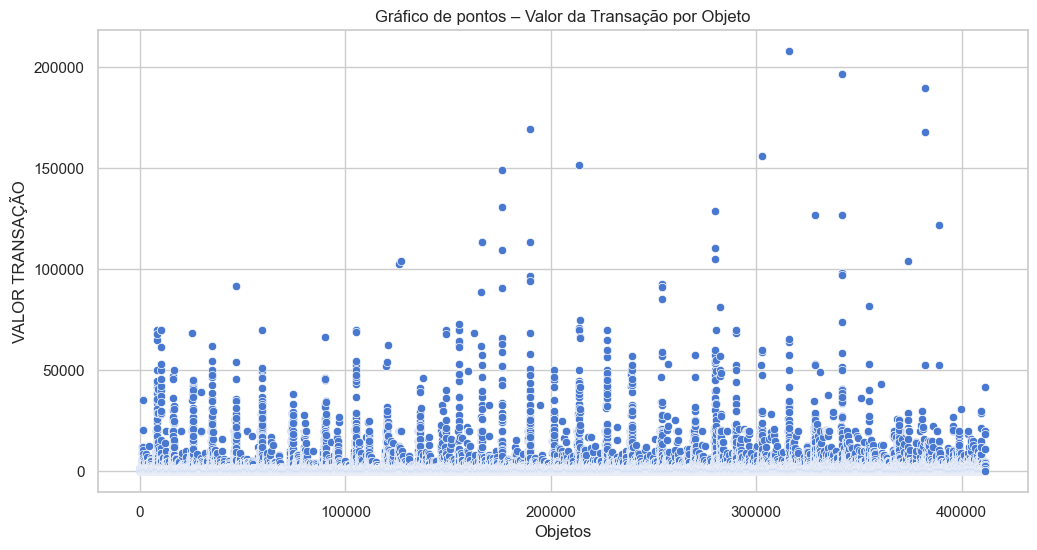

In [10]:
sns.scatterplot(
    x=df.index,
    y=df['VALOR TRANSAÇÃO']
)

plt.xlabel('Objetos')
plt.ylabel('VALOR TRANSAÇÃO')
plt.title('Gráfico de pontos – Valor da Transação por Objeto')
plt.show()

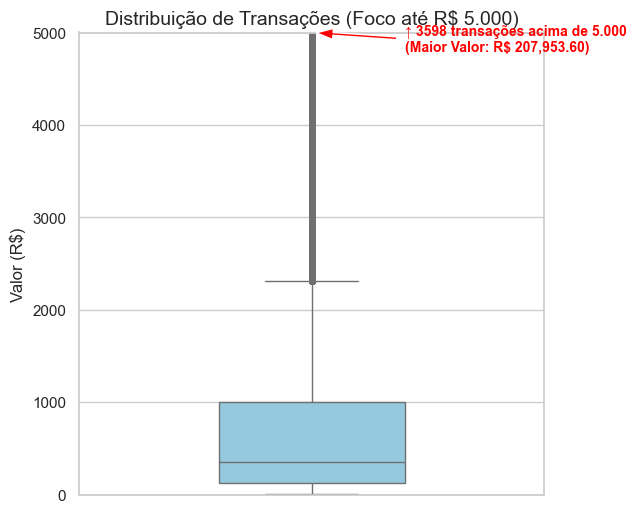

In [11]:
# 1. Tamanho da figura
plt.figure(figsize=(6, 6))

# 2. Criar o boxplot
ax = sns.boxplot(y=df['VALOR TRANSAÇÃO'], width=0.4, color='skyblue', fliersize=4)

# 3. Fixar o limite em 5000
plt.ylim(0, 5000)

# 4. Calcular quantos outliers ficaram de fora para informar o usuário
n_outliers_ocultos = df[df['VALOR TRANSAÇÃO'] > 5000].shape[0]
valor_maximo = df['VALOR TRANSAÇÃO'].max()

# 5. Adicionar a indicação visual (Texto + Seta)
if n_outliers_ocultos > 0:
    plt.annotate(
        f'↑ {n_outliers_ocultos} transações acima de 5.000\n(Maior Valor: R$ {valor_maximo:,.2f})', 
        xy=(0, 5000),           # Onde a seta aponta (topo do gráfico)
        xytext=(0.2, 4800),     # Onde o texto fica (um pouco abaixo do topo)
        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
        fontsize=10, 
        color='red', 
        fontweight='bold',
        ha='left'
    )

plt.title("Distribuição de Transações (Foco até R$ 5.000)", fontsize=14)
plt.ylabel("Valor (R$)", fontsize=12)

plt.show()

### 4.1.2 Valor da Transação por Categoria

In [29]:
resumo = (
    df.groupby('TRANSAÇÃO', as_index=False)['VALOR TRANSAÇÃO']
      .sum()
      .rename(columns={'VALOR TRANSAÇÃO': 'VALOR_TOTAL'})
)

valores = resumo.sort_values('VALOR_TOTAL', ascending=False).round(2)

print("Total de compra por tipo de transação:")
print(
    valores.to_string(
        index=False,
        formatters={
            'VALOR_TOTAL': lambda x: f'{x:,.2f}'
            .replace(',', 'X')
            .replace('.', ',')
            .replace('X', '.')
        }
    )
)

Total de compra por tipo de transação:
                          TRANSAÇÃO    VALOR_TOTAL
  Informações protegidas por sigilo 133.767.788,30
            COMPRA A/V - R$ - APRES 120.398.963,73
                  SAQUE CASH/ATM BB  22.760.175,00
          COMPRA A/V - INT$ - APRES   2.298.692,03
               SAQUE - INT$ - APRES   1.965.542,97
 SAQUE MANUAL-CARTOES BB NA AGENCIA     209.998,00
COMP A/V-SOL DISP C/CLI-R$ ANT VENC       3.050,05
                 SAQUE - R$ - APRES       2.530,00


### 4.1.3 Maiores Valores de Transação por Portador e Favorecido

In [31]:
top_3_maiores = (
    df.sort_values('VALOR TRANSAÇÃO', ascending=False)
      .head(3)[['CPF PORTADOR', 'VALOR TRANSAÇÃO', 'NOME FAVORECIDO']]
)

print("Top 3 maiores transações:")
print(top_3_maiores)

top_3_menores = (
    df.sort_values('VALOR TRANSAÇÃO', ascending=True)
      .head(3)[['CPF PORTADOR', 'VALOR TRANSAÇÃO', 'NOME FAVORECIDO']]
)

print("\nTop 3 menores transações:")
print(top_3_menores)

Top 3 maiores transações:
          CPF PORTADOR  VALOR TRANSAÇÃO                 NOME FAVORECIDO
316101             NaN        207953.60                        Sigiloso
341824             NaN        196690.82                        Sigiloso
382414  ***.651.497-**        189650.00  MARAJO LOCACAO E SERVICOS LTDA

Top 3 menores transações:
          CPF PORTADOR  VALOR TRANSAÇÃO          NOME FAVORECIDO
384200  ***.781.396-**             0.04      AUTO POSTO CC3 LTDA
382883  ***.415.362-**             0.10          J. R. LIRA LTDA
191253  ***.713.597-**             0.10  EXFRIAR AUTOMOTIVO LTDA


### 4.1.4 Portadores que mais consomem

In [35]:
resumo = (
    df.groupby('CPF PORTADOR', as_index=False)['VALOR TRANSAÇÃO']
      .sum()
      .rename(columns={'VALOR TRANSAÇÃO': 'VALOR_TOTAL'})
)

top_3_maiores = resumo.sort_values('VALOR_TOTAL', ascending=False).head(3)
top_3_menores = resumo.sort_values('VALOR_TOTAL', ascending=True).head(3)

print("3 maiores valores de consumo por CPF:")
print(top_3_maiores)

print("\n3 menores valores de consumo por CPF:")
print(top_3_menores)

3 maiores valores de consumo por CPF:
        CPF PORTADOR  VALOR_TOTAL
7828  ***.791.329-**   1220451.04
1525  ***.152.124-**    664590.25
5462  ***.543.101-**    646645.52

3 menores valores de consumo por CPF:
        CPF PORTADOR  VALOR_TOTAL
1636  ***.162.027-**          1.0
90    ***.007.398-**          1.0
8819  ***.890.293-**          1.0


### 4.2 Estatísticas Descritivas - Atributos Categóricos

In [12]:
print('\n=== Estatísticas descritivas (atributos categóricos) ===')
display(df.describe(include='object'))


=== Estatísticas descritivas (atributos categóricos) ===


,NOME ÓRGÃO SUPERIOR,NOME ÓRGÃO,NOME UNIDADE GESTORA,CPF PORTADOR,NOME PORTADOR,NOME FAVORECIDO,TRANSAÇÃO
count,411652,411652,411652,312122,411652,411652,411652
unique,30,194,1255,9883,9932,60321,8
top,Ministério da Justiça e Segurança Pública,Polícia Federal,COORDENACAO GERAL DE ADMINISTRACAO CGAD/DLOG/,***.735.900-**,Sigiloso,Sigiloso,COMPRA A/V - R$ - APRES
freq,83599,79609,21527,1071,99530,99530,265854


### 4.2.1 Categorias de Transação

In [ ]:
print('=== Estatísticas descritivas do valor da transação ===')
display(df['VALOR NORMALIZADO'].describe().round(2))

### 4.3 Normalização dos Dados
Cria uma nova coluna com os valores de transação normalizados

**Técnicas comuns de normalização:**
- Min-Max Scaling: Transforma os valores para o intervalo [0, 1].
- Z-Score (Standardization): Centraliza na média 0 e desvio padrão 1.
- Utilizaremos StandardScaler (Z-Score) neste projeto, pois é mais robusto na presença de outliers que a normalização Min-Max.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['VALOR TRANSAÇÃO']])
df['VALOR NORMALIZADO'] = X_scaled

In [ ]:
print('=== Estatísticas descritivas do valor da transação ===')
display(df['VALOR NORMALIZADO'].describe().round(2))

=== Estatísticas descritivas do valor da transação ===


count    411652.00
mean         -0.00
std           1.00
min          -0.32
25%          -0.26
50%          -0.15
75%           0.15
max          95.77
Name: VALOR NORMALIZADO, dtype: float64

In [37]:
df.head(2)

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2022,1,***.177.590-**,EDSON LUIS GARCIA FAGUNDES,1368970000107,RANZAN & GRAF LTDA,COMPRA A/V - R$ - APRES,2021-12-08,40.6
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2022,1,***.725.752-**,VIVIANE CORREA LIMA,84646934000195,PORTOSOFT COMERCIO DE PRODUTOS DE INFORMATICA ...,COMPRA A/V - R$ - APRES,2021-12-01,225.0


## 5. Qualidade dos Dados

### 5.1 Fundamentação Teórica
Os principais problemas tratados nesta etapa são:

### 5.2 Dados Duplicados

In [ ]:
df[df.duplicated()]
print("Total de linhas:", len(df))
print("Duplicadas:", df.duplicated().sum())
df[df.duplicated(keep=False)].head(4)

Total de linhas: 411652
Duplicadas: 85606


,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,VALOR NORMALIZADO
202,22000,Ministério da Agricultura e Pecuária,22000,Ministério da Agricultura e Pecuária - Unidade...,130010,COMISSAO EXEC. DO PLANO DA LAV.CACAUEIRA/DF,2022,1,***.275.451-**,ANTONIO CARLOS DE SANTANA,-2,NAO SE APLICA,SAQUE CASH/ATM BB,2021-11-30,1000.00,0.146193
204,22000,Ministério da Agricultura e Pecuária,22000,Ministério da Agricultura e Pecuária - Unidade...,130010,COMISSAO EXEC. DO PLANO DA LAV.CACAUEIRA/DF,2022,1,***.275.451-**,ANTONIO CARLOS DE SANTANA,-2,NAO SE APLICA,SAQUE CASH/ATM BB,2021-11-30,1000.00,0.146193
228,22000,Ministério da Agricultura e Pecuária,22000,Ministério da Agricultura e Pecuária - Unidade...,130103,LABORATORIO FEDERAL DE DEFESA AGROPECUARIA/RS,2022,1,***.859.660-**,NILTON LUIS ROSA DOS SANTOS,7473735004179,SIM REDE DE POSTOS LTDA,COMPRA A/V - R$ - APRES,2021-12-20,189.44,-0.228332
229,22000,Ministério da Agricultura e Pecuária,22000,Ministério da Agricultura e Pecuária - Unidade...,130103,LABORATORIO FEDERAL DE DEFESA AGROPECUARIA/RS,2022,1,***.859.660-**,NILTON LUIS ROSA DOS SANTOS,7473735004179,SIM REDE DE POSTOS LTDA,COMPRA A/V - R$ - APRES,2021-12-20,189.44,-0.228332


### 5.2 Agregação dos Dados
Nesta etapa, criamos um novo dataframe agrupando os dados por CPF do portador do cartão. O objetivo é transformar os dados em um perfil de comportamento por portador do cartão, visando que os algoritmos de mineração identifiquem padrões e anomalias do usuário.

- Cada linha da base agregada representa um portador

In [ ]:
# TODO: Ajustar os nomes das colunas conforme a base real do CPGF
col_cpf = "CPF PORTADOR"
col_valor = "VALOR TRANSAÇÃO"

df_agregado = df.groupby(col_cpf).agg(
     total_gasto  = (col_valor, "sum"),
     media_gasto  = (col_valor, "mean"),
     qtd_transacoes = (col_valor, "count"),
     max_gasto    = (col_valor, "max")
 ).reset_index()

print(f"Portadores únicos: {len(df_agregado[col_cpf].unique())}")

Portadores únicos: 9883


In [ ]:
print("\n=== Primeiras linhas do DataFrame agregado ===")
display(df_agregado.head(10))
print("\n=== Estatísticas descritivas do perfil agregado ===")
display(df_agregado.describe().round(2))
print("Agregação concluída.")


=== Primeiras linhas do DataFrame agregado ===


,CPF PORTADOR,total_gasto,media_gasto,qtd_transacoes,max_gasto
0,***.000.021-**,50093.15,279.850000,179,800.00
1,***.000.060-**,828.00,828.000000,1,828.00
2,***.000.230-**,1661.96,151.087273,11,694.10
3,***.000.251-**,1250.00,625.000000,2,1000.00
4,***.000.379-**,3844.95,349.540909,11,1200.00
5,***.000.384-**,1167.99,166.855714,7,299.99
6,***.000.478-**,8528.51,164.009808,52,1000.00
7,***.000.567-**,2849.30,237.441667,12,1237.95
8,***.000.632-**,8950.00,639.285714,14,1000.00
9,***.000.716-**,197.40,8.972727,22,9.20



=== Estatísticas descritivas do perfil agregado ===


,total_gasto,media_gasto,qtd_transacoes,max_gasto
count,9883.00,9883.00,9883.00,9883.00
mean,14938.68,674.79,31.58,1902.26
std,30997.99,2458.03,53.90,4076.50
min,1.00,1.00,1.00,1.00
25%,2139.30,249.90,5.00,700.00
50%,6157.53,414.74,14.00,1085.50
75%,16377.44,708.56,35.00,1876.82
max,1220451.04,189650.00,1071.00,189650.00


Agregação concluída.


### 5.2.1 Normalização da base agregada

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_agregado[['total_gasto']])
df_agregado['VALOR NORMALIZADO'] = X_scaled

NameError: name 'df_agregado' is not defined

### 5.3 Tratamento de Ausência de Valores
Valores ausentes podem surgir por falhas de coleta ou campos opcionais. A estratégia padrão inclui eliminar as linhas com valores ausentes em atributos críticos. a principio, nao eliminamos pois nao usaremos as colunas que contem dados nulos no modelo.

(*discutir depois aula 2 qualidade dos dados)

### 5.4 Tratamento de Ruído e Dados Inconsistentes
Para objetos, ruído é um objeto estranho. Para atributos, ruído refere-se à modificação dos valores originais. entendemos que ruído pode confundir o algoritmo.

(verificar se saque pode ser um ruido)

In [34]:
# --- 3.2 Análise de valores ausentes ---
print('=== Valores ausentes por coluna ===')
nulos = df.isnull().sum()
nulos_pct = (nulos / len(df)) * 100
resumo_nulos = pd.DataFrame({'Nulos': nulos, '% do Total': nulos_pct.round(2)})
display(resumo_nulos[resumo_nulos['Nulos'] > 0].sort_values('Nulos', ascending=False))
     

=== Valores ausentes por coluna ===


,Nulos,% do Total
CPF PORTADOR,99530,24.18
DATA TRANSAÇÃO,99530,24.18


In [12]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 411652 entries, 0 to 411651
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   CÓDIGO ÓRGÃO SUPERIOR   411652 non-null  int64         
 1   NOME ÓRGÃO SUPERIOR     411652 non-null  str           
 2   CÓDIGO ÓRGÃO            411652 non-null  int64         
 3   NOME ÓRGÃO              411652 non-null  str           
 4   CÓDIGO UNIDADE GESTORA  411652 non-null  int64         
 5   NOME UNIDADE GESTORA    411652 non-null  str           
 6   ANO EXTRATO             411652 non-null  int64         
 7   MÊS EXTRATO             411652 non-null  int64         
 8   CPF PORTADOR            312122 non-null  str           
 9   NOME PORTADOR           411652 non-null  str           
 10  CNPJ OU CPF FAVORECIDO  411652 non-null  int64         
 11  NOME FAVORECIDO         411652 non-null  str           
 12  TRANSAÇÃO               411652 non-null  

In [35]:
df.to_csv("TesteDF.csv")